In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt

## 2023

In [2]:
header_2023 = pd.read_csv(r"Z:\HeadersCombined\all_unpacked_images_metadata_2023.csv", index_col=0, low_memory=False)
print(header_2023.shape)

(300456, 145)


2023 metadata (139993, 145)
2023 drop na speed (132068, 145)
2023 drop na alt (132068, 145)
IQRs, 0.07 kn
IQRa, 0.27 m
Speeds: P25 1.49, P50 1.53, P75 1.56
Altitudes: P25 1.72, P50 1.78, P75 1.99


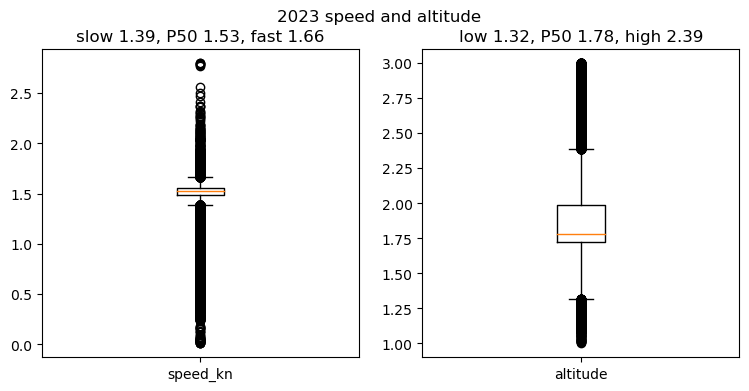

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (9,4))
df_2023 = header_2023[header_2023.Usability == "Usable"]
print("2023 metadata", df_2023.shape)
df_2023 = df_2023.dropna(subset="Speed_kn")
print("2023 drop na speed", df_2023.shape)
df_2023 = df_2023.dropna(subset="DistanceToBottom_m")
print("2023 drop na alt", df_2023.shape)
collects = df_2023.collect_id_x.unique()
speeds = df_2023.Speed_kn.dropna()
altitudes = df_2023.DistanceToBottom_m.dropna()
filter1 = speeds>0
filter2 = altitudes>1
speeds = speeds[filter1][filter2]
altitudes = altitudes[filter1][filter2]
p75s = np.percentile(speeds, 75)
p50s = np.percentile(speeds, 50)
p25s = np.percentile(speeds, 25)
p75a = np.percentile(altitudes, 75)
p50a = np.percentile(altitudes, 50)
p25a = np.percentile(altitudes, 25)
ax[0].boxplot(speeds, labels=["speed_kn"])
IQRs = p75s - p25s
IQRa = p75a - p25a
print(f"IQRs, {IQRs:0.2f} kn")
print(f"IQRa, {IQRa:0.2f} m")
ax[0].set_title(f"slow {p25s-1.5*IQRs:0.2f}, P50 {p50s:0.2f}, fast {p75s+1.5*IQRs:0.2f}")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
ax[1].boxplot(altitudes, labels=["altitude"])
ax[1].set_title(f"low {p25a-1.5*IQRa:0.2f}, P50 {p50a:0.2f}, high {p75a+1.5*IQRa:0.2f}")
plt.suptitle("2023 speed and altitude")
plt.show()


rolling 10 speed 131552
rolling 10 speed, filtered 70
rolling 10 altitude 131552
rolling 10 altitude, filtered 70


Text(0, 0.5, 'altitude m')

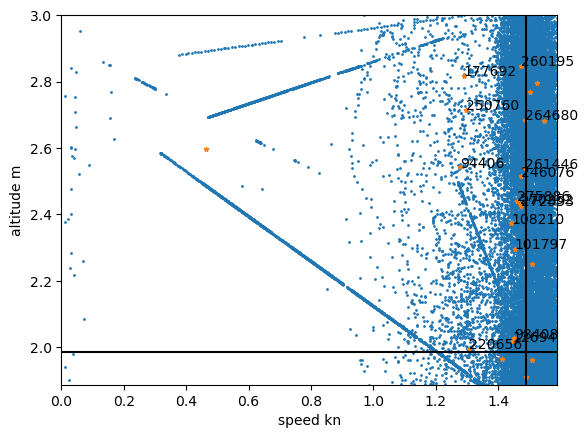

In [4]:
win = 4
rollings = speeds.rolling(win).mean()
print("rolling 10 speed", len(rollings))
diff = np.array([rollings.index[0]]+ [rollings.index[i+1] - rollings.index[i] for i in range(len(rollings.index)-1)])
dfilter = diff>=500
speed_idx = rollings[dfilter].dropna()
print("rolling 10 speed, filtered", len(speed_idx))
# altitude
rollinga = altitudes.rolling(win).mean()
print("rolling 10 altitude", len(rollinga))
alt_idx = rollinga[dfilter].dropna()
print("rolling 10 altitude, filtered", len(alt_idx))

plt.scatter(speeds, altitudes, s=1, )
plt.scatter(speed_idx, alt_idx, s=10, marker="*")

# Ranges for low speed and high altitude
speed_low = (speed_idx<p25s) & (speed_idx>0.5)
alt_high = alt_idx>p75a
# Dataframe constructor
speed_idx_low = speed_idx[alt_high & speed_low]
alt_idx_high = alt_idx[alt_high & speed_low]
df = pd.DataFrame(data = np.c_[speed_idx_low.values, alt_idx_high.values], columns=[speed_idx_low.name, alt_idx_high.name], index = speed_idx_low.index)

labels = speed_idx_low.index
all_labels = speeds.index[:1000]
for i in range(len(labels)): 
    plt.annotate(labels[i], (speed_idx_low.values[i], alt_idx_high.values[i]))
plt.vlines(p25s, 0, 3, color='k')
plt.hlines(p75a, 0, 3, color='k')
# plt.vlines(p25s-1.5*IQRs, 0, 3, color='k')
# plt.hlines(p75a+1.5*IQRa, 0, 3, color='k')
plt.xlim(0, p25s+0.1)
plt.ylim(p75a-0.1, 3)
plt.xlabel("speed kn")
plt.ylabel("altitude m")

In [164]:
print("2023 Summary")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
df

2023 Summary
Speeds: P25 1.49, P50 1.53, P75 1.56
Altitudes: P25 1.72, P50 1.78, P75 1.99


,Speed_kn,DistanceToBottom_m
13449,1.447348,2.018391
95182,1.277806,2.542037
99184,1.451184,2.027304
102573,1.452566,2.296108
108986,1.442642,2.373054
178468,1.289961,2.816418
221432,1.306552,1.995032
246852,1.472978,2.514763
251536,1.295720,2.714678
260971,1.472073,2.846472


In [165]:
import datetime as dt
df2 = header_2023.loc[df.index, ["filename", "Time_s","Time_UTC", "DistanceToBottom_m", "Speed_kn", "filename", "collect_id_x"]]
df2['datetime'] = pd.to_datetime(df2.Time_s,unit='s', utc=True)
df2['est_time'] = df2['datetime'].dt.tz_convert('US/Eastern')
df2.to_csv(r"C:\Users\ageglio\ageglio-1\bubbler\2023_HighAlt_LowSpeed\High_alt_low_speed.csv")
df2

,filename,Time_s,Time_UTC,DistanceToBottom_m,Speed_kn,filename,collect_id_x,datetime,est_time
13449,PI_1684787125_728.png,1.684787e+09,08:15:20.728355,2.758226,1.240000,PI_1684787125_728.png,20230522_001_Iver3098_ABS2,2023-05-22 20:25:25.728355328+00:00,2023-05-22 16:25:25.728355328-04:00
95182,PI_1687639469_798.png,1.687639e+09,20:44:18.428564,2.962857,1.448571,PI_1687639469_798.png,20230624_002_Iver3098_ABS2,2023-06-24 20:44:29.797971456+00:00,2023-06-24 16:44:29.797971456-04:00
99184,PI_1687800841_222.png,1.687801e+09,17:33:49.261729,2.009531,1.280198,PI_1687800841_222.png,20230626_001_Iver3098_ABS2,2023-06-26 17:34:01.221914112+00:00,2023-06-26 13:34:01.221914112-04:00
102573,PI_1687961588_830.png,1.687962e+09,14:12:56.679258,2.515659,1.596793,PI_1687961588_830.png,20230628_001_Iver3098_ABS2,2023-06-28 14:13:08.829905152+00:00,2023-06-28 10:13:08.829905152-04:00
108986,PI_1688744141_441.png,1.688744e+09,15:35:27.735410,1.847354,1.560000,PI_1688744141_441.png,20230707_001_Iver3098_ABS2,2023-07-07 15:35:41.441015040+00:00,2023-07-07 11:35:41.441015040-04:00
178468,PI_1690236092_904.png,1.690236e+09,21:58:37.903736,2.991888,1.241888,PI_1690236092_904.png,20230724_004_Iver3098_ABS2,2023-07-24 22:01:32.903736064+00:00,2023-07-24 18:01:32.903736064-04:00
221432,PI_1691870096_258.png,1.691870e+09,19:51:32.455392,2.077230,1.188921,PI_1691870096_258.png,20230812_002_Iver3069_ABS2,2023-08-12 19:54:56.258353152+00:00,2023-08-12 15:54:56.258353152-04:00
246852,PI_1692742906_687.png,1.692743e+09,22:18:25.291931,2.573291,2.078758,PI_1692742906_687.png,20230822_001_Iver3069_ABS2,2023-08-22 22:21:46.687231488+00:00,2023-08-22 18:21:46.687231488-04:00
251536,PI_1692897336_871.png,1.692897e+09,17:12:16.387447,2.406385,1.571062,PI_1692897336_871.png,20230824_001_Iver3069_ABS2,2023-08-24 17:15:36.871098624+00:00,2023-08-24 13:15:36.871098624-04:00
260971,PI_1693150470_457.png,1.693150e+09,15:31:09.859082,2.980000,1.430000,PI_1693150470_457.png,20230827_003_Iver3069_ABS2,2023-08-27 15:34:30.456515072+00:00,2023-08-27 11:34:30.456515072-04:00


# 2022

In [6]:
header_2022 = pd.read_csv(r"Z:\HeadersCombined\all_unpacked_images_metadata_2022.csv", index_col=0, low_memory=False)
print(header_2022.shape)

(241828, 145)


2022 metadata (113769, 145)
2022 drop na speed (105976, 145)
2022 drop na alt (105976, 145)
IQRs, 0.07 kn
IQRa, 0.27 m
Speeds: P25 1.48, P50 1.51, P75 1.55
Altitudes: P25 1.62, P50 1.75, P75 1.88


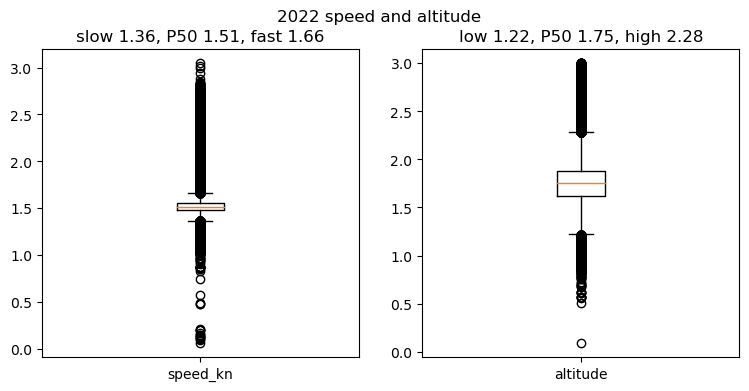

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (9,4))
df_2022 = header_2022[header_2022.Usability == "Usable"]
print("2022 metadata", df_2022.shape)
df_2022 = df_2022.dropna(subset="Speed_kn")
print("2022 drop na speed", df_2022.shape)
df_2022 = df_2022.dropna(subset="DistanceToBottom_m")
print("2022 drop na alt", df_2022.shape)
collects = df_2022.collect_id_x.unique()
speeds = df_2022.Speed_kn.dropna()
altitudes = df_2022.DistanceToBottom_m.dropna()
filter1 = speeds>0
filter2 = altitudes>0
speeds = speeds[filter1][filter2]
altitudes = altitudes[filter1][filter2]
p75s = np.percentile(speeds, 75)
p50s = np.percentile(speeds, 50)
p25s = np.percentile(speeds, 25)
p75a = np.percentile(altitudes, 75)
p50a = np.percentile(altitudes, 50)
p25a = np.percentile(altitudes, 25)
ax[0].boxplot(speeds, labels=["speed_kn"])
IQRs = p75s - p25s
IQRa = p75a - p25a
print(f"IQRs, {IQRs:0.2f} kn")
print(f"IQRa, {IQRa:0.2f} m")
ax[0].set_title(f"slow {p25s-1.5*IQRs:0.2f}, P50 {p50s:0.2f}, fast {p75s+1.5*IQRs:0.2f}")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
ax[1].boxplot(altitudes, labels=["altitude"])
ax[1].set_title(f"low {p25a-1.5*IQRa:0.2f}, P50 {p50a:0.2f}, high {p75a+1.5*IQRa:0.2f}")
plt.suptitle("2022 speed and altitude")
plt.show()

rolling speed 105967
rolling speed, filtered 51
rolling altitude 105967
rolling altitude, filtered 51


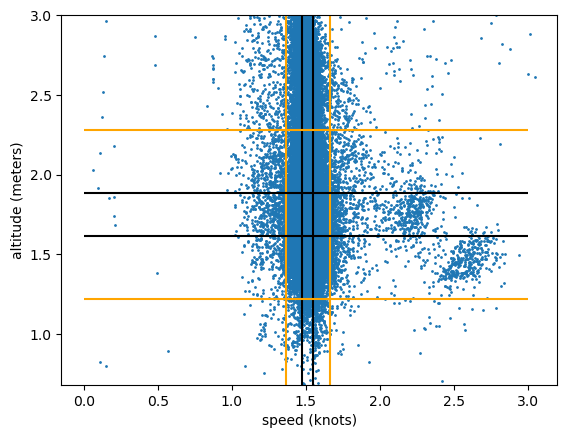

In [26]:
win = 4
rollings = speeds.rolling(win).mean()
print("rolling speed", len(rollings))
diff = np.array([rollings.index[0]]+ [rollings.index[i+1] - rollings.index[i] for i in range(len(rollings.index)-1)])
dfilter = diff>=500
speed_idx = rollings[dfilter].dropna()
print("rolling speed, filtered", len(speed_idx))
# altitude
rollinga = altitudes.rolling(win).mean()
print("rolling altitude", len(rollinga))
alt_idx = rollinga[dfilter].dropna()
print("rolling altitude, filtered", len(alt_idx))

plt.scatter(speeds, altitudes, s=1)
# plt.scatter(speed_idx, alt_idx, s=10, marker="*")

# Ranges for low speed and high altitude
speed_low = (speed_idx<p25s)
alt_high = alt_idx>p75a
# Dataframe constructor
speed_idx_low = speed_idx[alt_high & speed_low]
alt_idx_high = alt_idx[alt_high & speed_low]
df = pd.DataFrame(data = np.c_[speed_idx_low.values, alt_idx_high.values], columns=[speed_idx_low.name, alt_idx_high.name], index = speed_idx_low.index)

labels = speed_idx_low.index
# for i in range(len(labels)): 
#     plt.annotate(labels[i], (speed_idx_low.values[i], alt_idx_high.values[i]))
plt.vlines(p25s-1.5*IQRs, 0, 3, color='orange')
plt.vlines(p25s, 0, 3, color='k')
plt.vlines(p75s, 0, 3, color='k')
plt.vlines(p75s+1.5*IQRs, 0, 3, color='orange')
plt.hlines(p25a-1.5*IQRa, 0, 3, color='orange')
plt.hlines(p25a, 0, 3, color='k')
plt.hlines(p75a, 0, 3, color='k')
plt.hlines(p75a+1.5*IQRa, 0, 3, color='orange')
# plt.vlines(p25s-1.5*IQRs, 0, 3, color='k')
# plt.hlines(p75a+1.5*IQRa, 0, 3, color='k')
# plt.xlim(0, p25s+0.5)
plt.ylim(p75a-1.2, 3)
plt.xlabel("speed (knots)")
plt.ylabel("altitude (meters)")
plt.savefig("2022_speed_altitude.png", dpi=600)

In [171]:
print("2022 Summary")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
df

2022 Summary
Speeds: P25 1.48, P50 1.51, P75 1.55
Altitudes: P25 1.62, P50 1.75, P75 1.88


,Speed_kn,DistanceToBottom_m
4851,1.473859,2.264391
10147,1.400809,2.306386
11583,1.391106,2.136978
48423,1.368955,2.094883
61581,1.192378,2.708313
64046,1.451152,2.768921
83037,1.396875,2.673392
122144,1.421458,2.487447
132864,1.460209,2.225150
193689,1.414652,2.000260


In [172]:
df2 = header_2022.loc[df.index, ["filename", "Time_s","Time_UTC", "DistanceToBottom_m", "Speed_kn", "filename", "collect_id_x"]]
df2['datetime'] = pd.to_datetime(df2.Time_s,unit='s', utc=True)
df2['est_time'] = df2['datetime'].dt.tz_convert('US/Eastern')
df2.to_csv(r"C:\Users\ageglio\ageglio-1\bubbler\2022_HighAlt_LowSpeed\High_alt_low_speed.csv")
df2

,filename,Time_s,Time_UTC,DistanceToBottom_m,Speed_kn,filename,collect_id_x,datetime,est_time
4851,PI_1650465436_157.png,1.650465e+09,14:35:41.172593,2.792720,1.451725,PI_1650465436_157.png,20220420_001_Iver3069_ABS1,2022-04-20 14:37:16.156716800+00:00,2022-04-20 10:37:16.156716800-04:00
10147,PI_1650723986_519.png,1.650724e+09,14:24:50.789045,2.354304,1.452110,PI_1650723986_519.png,20220423_002_Iver3069_ABS1,2022-04-23 14:26:26.518872064+00:00,2022-04-23 10:26:26.518872064-04:00
11583,PI_1650729876_221.png,1.650730e+09,16:03:00.491021,2.159801,1.455099,PI_1650729876_221.png,20220423_002_Iver3069_ABS1,2022-04-23 16:04:36.220529920+00:00,2022-04-23 12:04:36.220529920-04:00
48423,PI_1655924558_508.png,1.655925e+09,19:00:57.275570,2.737245,1.562755,PI_1655924558_508.png,20220622_002_Iver3069_ABS1,2022-06-22 19:02:38.508183808+00:00,2022-06-22 15:02:38.508183808-04:00
61581,PI_1656441950_878.png,1.656442e+09,18:44:10.704650,2.685188,0.480000,PI_1656441950_878.png,20220628_001_Iver3069_ABS1,2022-06-28 18:45:50.878161920+00:00,2022-06-28 14:45:50.878161920-04:00
64046,PI_1656540370_154.png,1.656540e+09,22:04:29.720643,2.752352,1.504412,PI_1656540370_154.png,20220629_002_Iver3069_ABS1,2022-06-29 22:06:10.154161920+00:00,2022-06-29 18:06:10.154161920-04:00
83037,PI_1657465800_826.png,1.657466e+09,15:09:55.603931,2.383568,1.290197,PI_1657465800_826.png,20220710_001_Iver3098_ABS2,2022-07-10 15:10:00.826058752+00:00,2022-07-10 11:10:00.826058752-04:00
122144,PI_1658938168_282.png,1.658938e+09,16:09:29.000000,2.614771,1.375512,PI_1658938168_282.png,20220727_001_Iver3069_ABS2,2022-07-27 16:09:28.281591808+00:00,2022-07-27 12:09:28.281591808-04:00
132864,PI_1659983855_639.png,1.659984e+09,18:37:42.638985,2.132914,1.510834,PI_1659983855_639.png,20220808_001_Iver3069_ABS2,2022-08-08 18:37:35.638985472+00:00,2022-08-08 14:37:35.638985472-04:00
193689,PI_1661954405_172.png,1.661954e+09,14:00:05.946269,2.408597,1.479463,PI_1661954405_172.png,20220831_001_Iver3098_ABS2,2022-08-31 14:00:05.171903232+00:00,2022-08-31 10:00:05.171903232-04:00


# 2021

In [203]:
header_2021 = pd.read_csv(r"Z:\HeadersCombined\all_unpacked_images_metadata_2021.csv", index_col=0, low_memory=False)
print(header_2021.shape)

(252134, 145)


2021 metadata (96817, 145)
2021 drop na speed (93519, 145)
2021 drop na alt (93519, 145)
IQRs, 0.08 kn
IQRa, 0.21 m
Speeds: P25 1.47, P50 1.51, P75 1.55
Altitudes: P25 1.71, P50 1.79, P75 1.92


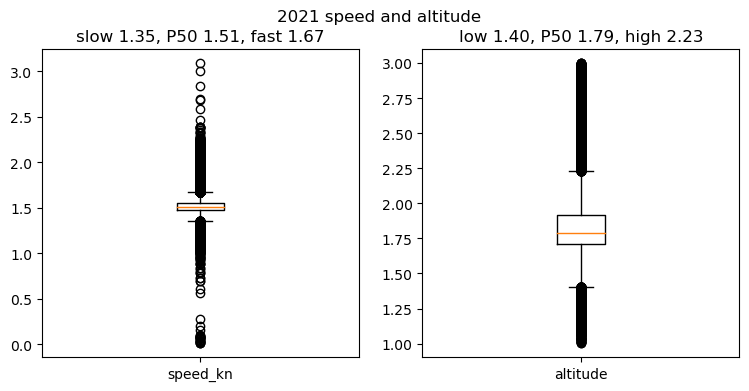

In [204]:
fig, ax = plt.subplots(1, 2, figsize = (9,4))
df_2021 = header_2021[header_2021.Usability == "Usable"]
print("2021 metadata", df_2021.shape)
df_2021 = df_2021.dropna(subset="Speed_kn")
print("2021 drop na speed", df_2021.shape)
df_2021 = df_2021.dropna(subset="DistanceToBottom_m")
print("2021 drop na alt", df_2021.shape)
collects = df_2021.collect_id_x.unique()
speeds = df_2021.Speed_kn.dropna()
altitudes = df_2021.DistanceToBottom_m.dropna()
filter1 = speeds>0
filter2 = altitudes>1
speeds = speeds[filter1][filter2]
altitudes = altitudes[filter1][filter2]
p75s = np.percentile(speeds, 75)
p50s = np.percentile(speeds, 50)
p25s = np.percentile(speeds, 25)
p75a = np.percentile(altitudes, 75)
p50a = np.percentile(altitudes, 50)
p25a = np.percentile(altitudes, 25)
ax[0].boxplot(speeds, labels=["speed_kn"])
IQRs = p75s - p25s
IQRa = p75a - p25a
print(f"IQRs, {IQRs:0.2f} kn")
print(f"IQRa, {IQRa:0.2f} m")
ax[0].set_title(f"slow {p25s-1.5*IQRs:0.2f}, P50 {p50s:0.2f}, fast {p75s+1.5*IQRs:0.2f}")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
ax[1].boxplot(altitudes, labels=["altitude"])
ax[1].set_title(f"low {p25a-1.5*IQRa:0.2f}, P50 {p50a:0.2f}, high {p75a+1.5*IQRa:0.2f}")
plt.suptitle("2021 speed and altitude")
plt.show()

rolling speed 93461
rolling speed, filtered 59
rolling altitude 93461
rolling altitude, filtered 59


Text(0, 0.5, 'altitude m')

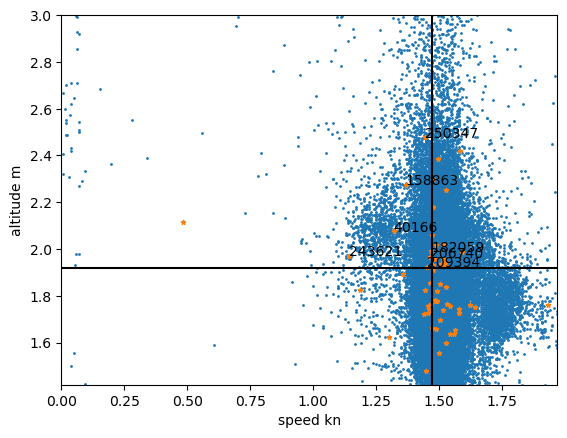

In [174]:
win = 4                         
rollings = speeds.rolling(win).mean()
print("rolling speed", len(rollings))
diff = np.array([rollings.index[0]]+ [rollings.index[i+1] - rollings.index[i] for i in range(len(rollings.index)-1)])
dfilter = diff>=500
speed_idx = rollings[dfilter].dropna()
print("rolling speed, filtered", len(speed_idx))
# altitude
rollinga = altitudes.rolling(win).mean()
print("rolling altitude", len(rollinga))
alt_idx = rollinga[dfilter].dropna()
print("rolling altitude, filtered", len(alt_idx))

plt.scatter(speeds, altitudes, s=1)
plt.scatter(speed_idx, alt_idx, s=10, marker="*")

# Ranges for low speed and high altitude
speed_low = (speed_idx<p25s) & (speed_idx>0.6)
alt_high = alt_idx>p75a
# Dataframe constructor
speed_idx_low = speed_idx[alt_high & speed_low]
alt_idx_high = alt_idx[alt_high & speed_low]
df = pd.DataFrame(data = np.c_[speed_idx_low.values, alt_idx_high.values], columns=[speed_idx_low.name, alt_idx_high.name], index = speed_idx_low.index)

labels = speed_idx_low.index
for i in range(len(labels)): 
    plt.annotate(labels[i], (speed_idx_low.values[i], alt_idx_high.values[i]))
plt.vlines(p25s, 0, 3, color='k')
plt.hlines(p75a, 0, 3, color='k')
# plt.vlines(p25s-1.5*IQRs, 0, 3, color='k')
# plt.hlines(p75a+1.5*IQRa, 0, 3, color='k')
plt.xlim(0, p25s+0.5)
plt.ylim(p75a-0.5, 3)
plt.xlabel("speed kn")
plt.ylabel("altitude m")

In [175]:
print("2021 Summary")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
df

2021 Summary
Speeds: P25 1.47, P50 1.51, P75 1.55
Altitudes: P25 1.71, P50 1.79, P75 1.92


,Speed_kn,DistanceToBottom_m
40166,1.319405,2.075970
158863,1.367335,2.273301
182059,1.467885,1.990441
206740,1.465253,1.964278
209394,1.453786,1.923123
243621,1.141653,1.970920
250347,1.444899,2.476917


In [178]:
df2 = header_2021.loc[df.index, ["filename", "Time_s","Time_UTC", "DistanceToBottom_m", "Speed_kn", "filename", "collect_id_x"]]
df2['datetime'] = pd.to_datetime(df2.Time_s,unit='s', utc=True)
df2['est_time'] = df2['datetime'].dt.tz_convert('US/Eastern')
df2.to_csv(r"C:\Users\ageglio\ageglio-1\bubbler\2021_HighAlt_LowSpeed\2021_High_alt_low_speed.csv")
df2

,filename,Time_s,Time_UTC,DistanceToBottom_m,Speed_kn,filename,collect_id_x,datetime,est_time
40166,PI_1624108104_539.png,1.624108e+09,13:08:12.455109,2.027247,0.970000,PI_1624108104_539.png,20210619_001_Iver3069_ABS1,2021-06-19 13:08:24.539158016+00:00,2021-06-19 09:08:24.539158016-04:00
158863,PI_1629900253_539.png,1.629900e+09,14:04:19.444334,2.653361,1.012227,PI_1629900253_539.png,20210825_001_Iver3069_ABS1,2021-08-25 14:04:13.538740224+00:00,2021-08-25 10:04:13.538740224-04:00
182059,PI_1631207988_282.png,1.631208e+09,17:19:58.602763,2.499729,1.334922,PI_1631207988_282.png,20210909_001_Iver3069_ABS1,2021-09-09 17:19:48.281644032+00:00,2021-09-09 13:19:48.281644032-04:00
206740,PI_1631742381_565.png,1.631742e+09,21:46:33.646516,1.770000,1.464752,PI_1631742381_565.png,20210915_003_Iver3069_ABS1,2021-09-15 21:46:21.564926976+00:00,2021-09-15 17:46:21.564926976-04:00
209394,PI_1631813131_857.png,1.631813e+09,17:25:43.182112,1.843642,1.440000,PI_1631813131_857.png,20210916_001_Iver3069_ABS1,2021-09-16 17:25:31.856968960+00:00,2021-09-16 13:25:31.856968960-04:00
243621,PI_1634830697_821.png,1.634831e+09,15:38:18.785562,2.645760,0.050000,PI_1634830697_821.png,20211102_001_Iver3069_ABS1,2021-10-21 15:38:17.821429248+00:00,2021-10-21 11:38:17.821429248-04:00
250347,PI_1638379984_864.png,1.638380e+09,17:32:46.512666,2.772849,1.415633,PI_1638379984_864.png,20211201_001_Iver3069_ABS1,2021-12-01 17:33:04.863580160+00:00,2021-12-01 12:33:04.863580160-05:00


# 2020

In [202]:
header_2020 = pd.read_csv(r"Z:\HeadersCombined\all_unpacked_images_metadata_2020.csv", index_col=0, low_memory=False)
print(header_2020.shape)

(112808, 123)


2020 metadata (51346, 123)
2020 drop na speed (50380, 123)
2020 drop na alt (50380, 123)
IQRs, 0.12 kn
IQRa, 0.33 m
Speeds: P25 1.47, P50 1.51, P75 1.59
Altitudes: P25 1.82, P50 1.94, P75 2.15


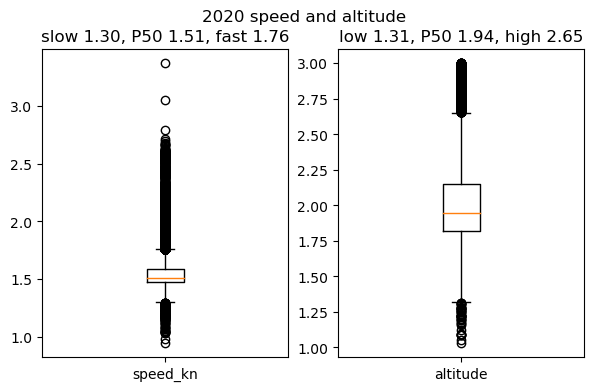

In [201]:
fig, ax = plt.subplots(1, 2, figsize = (7,4))
df_2020 = header_2020[header_2020.Usability == "Usable"]
print("2020 metadata", df_2020.shape)
df_2020 = df_2020.dropna(subset="Speed_kn")
print("2020 drop na speed", df_2020.shape)
df_2020 = df_2020.dropna(subset="DistanceToBottom_m")
print("2020 drop na alt", df_2020.shape)
collects = df_2020.collect_id_x.unique()
speeds = df_2020.Speed_kn.dropna()
altitudes = df_2020.DistanceToBottom_m.dropna()
filter1 = speeds>0
filter2 = altitudes>1
speeds = speeds[filter1][filter2]
altitudes = altitudes[filter1][filter2]
p75s = np.percentile(speeds, 75)
p50s = np.percentile(speeds, 50)
p25s = np.percentile(speeds, 25)
p75a = np.percentile(altitudes, 75)
p50a = np.percentile(altitudes, 50)
p25a = np.percentile(altitudes, 25)
ax[0].boxplot(speeds, labels=["speed_kn"])
IQRs = p75s - p25s
IQRa = p75a - p25a
print(f"IQRs, {IQRs:0.2f} kn")
print(f"IQRa, {IQRa:0.2f} m")
ax[0].set_title(f"slow {p25s-1.5*IQRs:0.2f}, P50 {p50s:0.2f}, fast {p75s+1.5*IQRs:0.2f}")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
ax[1].boxplot(altitudes, labels=["altitude"])
ax[1].set_title(f"low {p25a-1.5*IQRa:0.2f}, P50 {p50a:0.2f}, high {p75a+1.5*IQRa:0.2f}")
plt.suptitle("2020 speed and altitude")
plt.show()

rolling speed 50373
rolling speed, filtered 55
rolling altitude 50373
rolling altitude, filtered 55


Text(0, 0.5, 'altitude m')

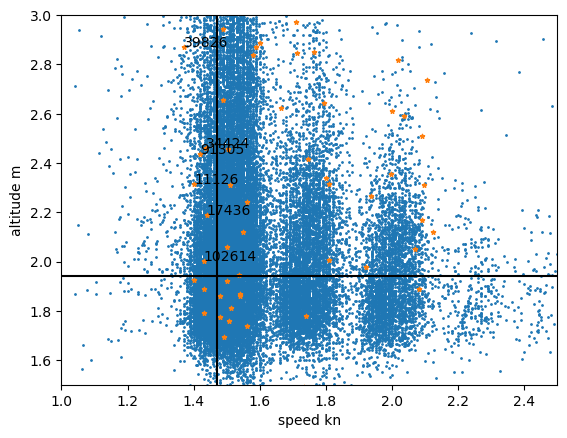

In [200]:
win = 1
rollings = speeds.rolling(win).mean()
print("rolling speed", len(rollings))
diff = np.array([rollings.index[0]]+ [rollings.index[i+1] - rollings.index[i] for i in range(len(rollings.index)-1)])
dfilter = diff>=100
speed_idx = rollings[dfilter].dropna()
print("rolling speed, filtered", len(speed_idx))
# altitude
rollinga = altitudes.rolling(win).mean()
print("rolling altitude", len(rollinga))
alt_idx = rollinga[dfilter].dropna()
print("rolling altitude, filtered", len(alt_idx))

plt.scatter(speeds, altitudes, s=1)
plt.scatter(speed_idx, alt_idx, s=10, marker="*")

# Ranges for low speed and high altitude
speed_low = (speed_idx<p25s) & (speed_idx>0.6)
alt_high = alt_idx>p50a
# Dataframe constructor
speed_idx_low = speed_idx[alt_high & speed_low]
alt_idx_high = alt_idx[alt_high & speed_low]
df = pd.DataFrame(data = np.c_[speed_idx_low.values, alt_idx_high.values], columns=[speed_idx_low.name, alt_idx_high.name], index = speed_idx_low.index)

labels = speed_idx_low.index
for i in range(len(labels)): 
    plt.annotate(labels[i], (speed_idx_low.values[i], alt_idx_high.values[i]))
plt.vlines(p25s, 0, 3, color='k')
plt.hlines(p50a, 0, 3, color='k')
# plt.vlines(p25s-1.5*IQRs, 0, 3, color='k')
# plt.hlines(p75a+1.5*IQRa, 0, 3, color='k')
plt.xlim(1, 2.5)
plt.ylim(1.5, 3)
plt.xlabel("speed kn")
plt.ylabel("altitude m")

In [195]:
print("2020 Summary")
print(f"Speeds: P25 {p25s:0.2f}, P50 {p50s:0.2f}, P75 {p75s:0.2f}")
print(f"Altitudes: P25 {p25a:0.2f}, P50 {p50a:0.2f}, P75 {p75a:0.2f}")
df

2020 Summary
Speeds: P25 1.47, P50 1.51, P75 1.59
Altitudes: P25 1.82, P50 1.94, P75 2.15


,Speed_kn,DistanceToBottom_m
11126,1.402219,2.315562
17436,1.440000,2.188748
34424,1.438075,2.460963
39826,1.370000,2.870584
91305,1.420000,2.436491
102614,1.430000,2.004062


In [196]:
df2 = header_2020.loc[df.index, ["filename", "Time_s","Time_UTC", "DistanceToBottom_m", "Speed_kn", "filename", "collect_id_x"]]

df2.to_csv(r"C:\Users\ageglio\ageglio-1\bubbler\2020_HighAlt_LowSpeed\2021_High_alt_low_speed.csv")
df2

,filename,Time_s,Time_UTC,DistanceToBottom_m,Speed_kn,filename,collect_id_x,datetime,est_time
11126,PI_1596977712_953.png,1.596978e+09,55:12.0,2.315562,1.402219,PI_1596977712_953.png,20200809_001_Iver3069_ABS1,2020-08-09 12:55:13+00:00,2020-08-09 08:55:13-04:00
17436,PI_1597328354_809.png,1.597328e+09,13:55.8,2.188748,1.440000,PI_1597328354_809.png,20200813_001_Iver3069_ABS1,2020-08-13 14:19:15+00:00,2020-08-13 10:19:15-04:00
34424,PI_1597788010_816.png,1.597788e+09,45:01.8,2.460963,1.438075,PI_1597788010_816.png,20200818_002_Iver3069_ABS1,2020-08-18 22:00:11+00:00,2020-08-18 18:00:11-04:00
39826,PI_1597937742_595.png,1.597938e+09,30:21.6,2.870584,1.370000,PI_1597937742_595.png,20200820_001_Iver3069_ABS1,2020-08-20 15:35:43+00:00,2020-08-20 11:35:43-04:00
91305,PI_1600253303_983.png,1.600253e+09,42:56.0,2.436491,1.420000,PI_1600253303_983.png,20200916_001_Iver3069_ABS1,2020-09-16 10:48:24+00:00,2020-09-16 06:48:24-04:00
102614,PI_1600598916_992.png,1.600599e+09,42:58.0,2.004062,1.430000,PI_1600598916_992.png,20200920_001_Iver3069_ABS1,2020-09-20 10:48:37+00:00,2020-09-20 06:48:37-04:00


# Archive

In [ ]:
rolling10s = speeds.rolling(10).mean()
slow_idx = rolling10s[(rolling10s>=1.46) & (rolling10s<=1.48)]
print(len(slow_idx))
diff = np.array([slow_idx.index[0]]+ [slow_idx.index[i+1] - slow_idx.index[i] for i in range(len(slow_idx.index)-1)])
slow_idx = slow_idx[diff>=500]
len(slow_idx)
rolling10a = altitudes.rolling(10).mean()
high_idx = rolling10a[(rolling10a>=1.96)]
print(len(high_idx))
diff = np.array([high_idx.index[0]]+ [high_idx.index[i+1] - high_idx.index[i] for i in range(len(high_idx.index)-1)])
high_idx = high_idx[diff>=500]
len(high_idx)

In [10]:
med_idx = rolling10[(rolling10>=1.52999) & (rolling10<=1.53001)]
print(len(med_idx))
diff = np.array([med_idx.index[0]]+ [med_idx.index[i+1] - med_idx.index[i] for i in range(len(med_idx.index)-1)])
med_idx = med_idx[diff>=500]
len(med_idx)

NameError: name 'rolling10' is not defined

In [ ]:
fast_idx = rolling10[(rolling10>=1.54999) & (rolling10<=1.55003)]
print(len(fast_idx))
diff = np.array([fast_idx.index[0]]+ [fast_idx.index[i+1] - fast_idx.index[i] for i in range(len(fast_idx.index)-1)])
fast_idx = fast_idx[diff>=500]
len(fast_idx)

584


29

In [ ]:
idx = med_idx.index[29]
df_2023.loc[idx,["Time_s","Datetime", "DistanceToBottom_m", "Speed_kn", "filename", "collect_id_x"]]

IndexError: index 29 is out of bounds for axis 0 with size 29

## 2022

In [ ]:
header_2022 = pd.read_csv(r"Z:\HeadersCombined\all_unpacked_images_metadata_2022.csv", index_col=0, low_memory=False)
header_2022.shape

(111992, 148)

(6158, 148)
(5933, 148)
P25 1.47, P50 1.51, P75 1.55
IQR 0.08387037762166183


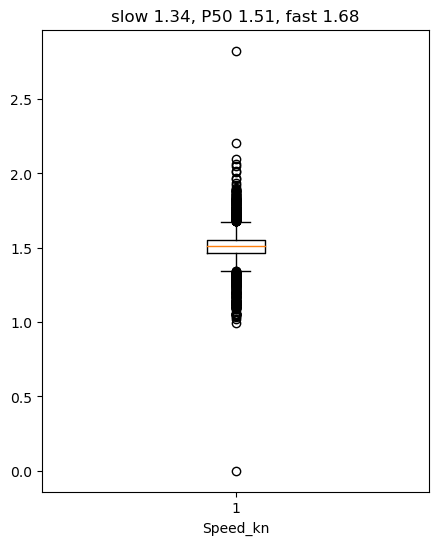

In [ ]:
fig, ax = plt.subplots(figsize = (5,6))
df_2022 = header_2022[header_2022.Usability == "Usable"]
df_2022 = df_2022[df_2022.CollectID.str.contains("ABS1")]
print(df_2022.shape)
df_2022 = df_2022.dropna(subset="Speed_kn")
print(df_2022.shape)
collects = df_2022.CollectID.unique()
speeds = df_2022.Speed_kn.dropna()
p75 = np.percentile(speeds, 75)
p50 = np.percentile(speeds, 50)
p25 = np.percentile(speeds, 25)
ax.boxplot(speeds)
ax.set_xlabel('Speed_kn')
print(f"P25 {p25:0.2f}, P50 {p50:0.2f}, P75 {p75:0.2f}")
IQR = p75 - p25
print("IQR", IQR)
ax.set_title(f"slow {p25-1.5*IQR:0.2f}, P50 {p50:0.2f}, fast {p75+1.5*IQR:0.2f}")
plt.show()

In [ ]:
rolling10 = speeds.rolling(10).mean()
slow_idx = rolling10[(rolling10>=1.20) & (rolling10<=1.45)]
print(len(slow_idx))
diff = np.array([slow_idx.index[0]]+ [slow_idx.index[i+1] - slow_idx.index[i] for i in range(len(slow_idx.index)-1)])
slow_idx = slow_idx[diff>=100]
len(slow_idx)

1036


29

<!-- [Friday 4:30 PM] Monhollon, Daniel (Contractor) -->
20 consecutive images from 60 unique locations (20 locations were the AUV was moving relatively slowly, 20 where it was faster, 20 where it was at average speed)